## Sales Trend Analysis
## Market Basket Analysis
## Customer Segmentation

### Link to the dataset: https://www.kaggle.com/datasets/shilongzhuang/pizza-sales

In [1]:
# Importing needed libraries.
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
# Set plot style for easy readability
sns.set_style("whitegrid")
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

In [3]:
# Loading our dataset.
df_pizza = pd.read_excel('Data Model - Pizza Sales.xlsx', index_col=None, engine='openpyxl')
print("The number of instances: ", len(df_pizza))
print(df_pizza.head())

The number of instances:  48620
   order_details_id  order_id       pizza_id  quantity order_date order_time  \
0                 1         1     hawaiian_m         1 2015-01-01   11:38:36   
1                 2         2  classic_dlx_m         1 2015-01-01   11:57:40   
2                 3         2  five_cheese_l         1 2015-01-01   11:57:40   
3                 4         2    ital_supr_l         1 2015-01-01   11:57:40   
4                 5         2     mexicana_m         1 2015-01-01   11:57:40   

   unit_price  total_price pizza_size pizza_category  \
0       13.25        13.25          M        Classic   
1       16.00        16.00          M        Classic   
2       18.50        18.50          L         Veggie   
3       20.75        20.75          L        Supreme   
4       16.00        16.00          M         Veggie   

                                   pizza_ingredients  \
0           Sliced Ham, Pineapple, Mozzarella Cheese   
1  Pepperoni, Mushrooms, Red Onions, R

In [4]:
df_pizza.shape

(48620, 12)

In [5]:
df_pizza.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   order_details_id   48620 non-null  int64         
 1   order_id           48620 non-null  int64         
 2   pizza_id           48620 non-null  object        
 3   quantity           48620 non-null  int64         
 4   order_date         48620 non-null  datetime64[ns]
 5   order_time         48620 non-null  object        
 6   unit_price         48620 non-null  float64       
 7   total_price        48620 non-null  float64       
 8   pizza_size         48620 non-null  object        
 9   pizza_category     48620 non-null  object        
 10  pizza_ingredients  48620 non-null  object        
 11  pizza_name         48620 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(6)
memory usage: 4.5+ MB


In [6]:
# Creating a copy of the dataset to work with
data = df_pizza.copy()
data.sample(5)

,order_details_id,order_id,pizza_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
18688,18689,8211,pepperoni_m,1,2015-05-17,20:54:45,12.50,12.50,M,Classic,"Mozzarella Cheese, Pepperoni",The Pepperoni Pizza
18959,18960,8327,cali_ckn_l,1,2015-05-20,12:16:15,20.75,20.75,L,Chicken,"Chicken, Artichoke, Spinach, Garlic, Jalapeno ...",The California Chicken Pizza
8063,8064,3538,pep_msh_pep_s,1,2015-03-01,13:25:47,11.00,11.00,S,Classic,"Pepperoni, Mushrooms, Green Peppers","The Pepperoni, Mushroom, and Peppers Pizza"
14832,14833,6495,pep_msh_pep_l,1,2015-04-19,19:45:58,17.50,17.50,L,Classic,"Pepperoni, Mushrooms, Green Peppers","The Pepperoni, Mushroom, and Peppers Pizza"
47772,47773,21003,big_meat_s,2,2015-12-23,12:35:26,12.00,24.00,S,Classic,"Bacon, Pepperoni, Italian Sausage, Chorizo Sau...",The Big Meat Pizza


In [7]:
# Clean Column Names
data.columns = data.columns.str.strip().str.lower()

In [8]:
# Convert date and time columns
data['order_date'] = pd.to_datetime(data['order_date'], errors='coerce')
data['order_time'] = data['order_time'].astype(str)
data[['hour', 'minute', 'second']] = data['order_time'].str.split(":", expand=True)
data['hour'] = data['hour'].astype(int)
data['order_month'] = data['order_date'].dt.month_name()
data['month_num'] = data['order_date'].dt.month
data['order_dayname'] = data['order_date'].dt.day_name()

In [9]:
# Reorder categories
MONTH_ORDER = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
DAY_ORDER = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
data['order_month'] = pd.Categorical(data['order_month'], categories=MONTH_ORDER, ordered=True)
data['order_dayname'] = pd.Categorical(data['order_dayname'], categories=DAY_ORDER, ordered=True)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   order_details_id   48620 non-null  int64         
 1   order_id           48620 non-null  int64         
 2   pizza_id           48620 non-null  object        
 3   quantity           48620 non-null  int64         
 4   order_date         48620 non-null  datetime64[ns]
 5   order_time         48620 non-null  object        
 6   unit_price         48620 non-null  float64       
 7   total_price        48620 non-null  float64       
 8   pizza_size         48620 non-null  object        
 9   pizza_category     48620 non-null  object        
 10  pizza_ingredients  48620 non-null  object        
 11  pizza_name         48620 non-null  object        
 12  hour               48620 non-null  int32         
 13  minute             48620 non-null  object        
 14  second

In [11]:
# Quick Overview
print("Total Rows and Columuns:", data.shape)
print("Missing Values:\n", data.isnull().sum())
print("Duplicated Rows:", data.duplicated().sum())

Total Rows and Columuns: (48620, 18)
Missing Values:
 order_details_id     0
order_id             0
pizza_id             0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
hour                 0
minute               0
second               0
order_month          0
month_num            0
order_dayname        0
dtype: int64
Duplicated Rows: 0


# Sales Analysis

In [12]:
# Sales Summary
print(f"\nTotal Sales: ${data['total_price'].sum():,.2f}")
print(f"Average Transaction Value: ${data['total_price'].mean():,.2f}")
print("Sales by Pizza Size:\n", data['pizza_size'].value_counts())


Total Sales: $817,860.05
Average Transaction Value: $16.82
Sales by Pizza Size:
 pizza_size
L      18526
M      15385
S      14137
XL       544
XXL       28
Name: count, dtype: int64


In [13]:
# Top selling pizzas

pizza_rank=data.groupby("pizza_name")["quantity"].count().sort_values(ascending=False)
print("Top selling pizzas overall:\n", pizza_rank.head(10))

Top selling pizzas overall:
 pizza_name
The Classic Deluxe Pizza        2416
The Barbecue Chicken Pizza      2372
The Hawaiian Pizza              2370
The Pepperoni Pizza             2369
The Thai Chicken Pizza          2315
The California Chicken Pizza    2302
The Spicy Italian Pizza         1887
The Sicilian Pizza              1887
The Southwest Chicken Pizza     1885
The Four Cheese Pizza           1850
Name: quantity, dtype: int64


In [14]:
# Analysing the highest sales category count for CHICKEN

highest=data.loc[data['pizza_category'] == "Chicken"]
highest=highest.groupby("pizza_name")["quantity"].sum().sort_values(ascending=False)
highest=highest[0:5]
highest

pizza_name
The Barbecue Chicken Pizza      2432
The Thai Chicken Pizza          2371
The California Chicken Pizza    2370
The Southwest Chicken Pizza     1917
The Chicken Alfredo Pizza        987
Name: quantity, dtype: int64

In [15]:
# Analysing the highest sales category count for CLASSIC

highest=data.loc[data['pizza_category'] == "Classic"]
highest=highest.groupby("pizza_name")["quantity"].sum().sort_values(ascending=False)
highest=highest[0:5]
highest

pizza_name
The Classic Deluxe Pizza    2453
The Hawaiian Pizza          2422
The Pepperoni Pizza         2418
The Big Meat Pizza          1914
The Napolitana Pizza        1464
Name: quantity, dtype: int64

In [16]:
# Analysing the highest sales category count for SUPREME

highest=data.loc[data['pizza_category'] == "Supreme"]
highest=highest.groupby("pizza_name")["quantity"].sum().sort_values(ascending=False)
highest=highest[0:5]
highest

pizza_name
The Sicilian Pizza                  1938
The Spicy Italian Pizza             1924
The Italian Supreme Pizza           1884
The Prosciutto and Arugula Pizza    1457
The Pepper Salami Pizza             1446
Name: quantity, dtype: int64

In [17]:
# Analysing the highest sales category count for VEGGIE

highest=data.loc[data['pizza_category'] == "Veggie"]
highest=highest.groupby("pizza_name")["quantity"].sum().sort_values(ascending=False)
highest=highest[0:5]
highest

pizza_name
The Four Cheese Pizza                1902
The Vegetables + Vegetables Pizza    1526
The Mexicana Pizza                   1484
The Spinach and Feta Pizza           1446
The Five Cheese Pizza                1409
Name: quantity, dtype: int64

In [18]:
# Analysing the lowest sales category count for CHICKEN

lowest=data.loc[data['pizza_category'] == "Chicken"]
lowest=lowest.groupby("pizza_name")["quantity"].sum().sort_values(ascending=True)
lowest=lowest[0:5]
lowest

pizza_name
The Chicken Pesto Pizza          973
The Chicken Alfredo Pizza        987
The Southwest Chicken Pizza     1917
The California Chicken Pizza    2370
The Thai Chicken Pizza          2371
Name: quantity, dtype: int64

In [19]:
# Analysing the lowest sales category count for CLASSIC

lowest=data.loc[data['pizza_category'] == "Classic"]
lowest=lowest.groupby("pizza_name")["quantity"].sum().sort_values(ascending=True)
lowest=lowest[0:5]
lowest

pizza_name
The Pepperoni, Mushroom, and Peppers Pizza    1359
The Greek Pizza                               1420
The Italian Capocollo Pizza                   1438
The Napolitana Pizza                          1464
The Big Meat Pizza                            1914
Name: quantity, dtype: int64

In [20]:
# Analysing the lowest sales category count for SUPREME

lowest=data.loc[data['pizza_category'] == "Supreme"]
lowest=lowest.groupby("pizza_name")["quantity"].sum().sort_values(ascending=True)
lowest=lowest[0:5]
lowest

pizza_name
The Brie Carre Pizza          490
The Calabrese Pizza           937
The Spinach Supreme Pizza     950
The Soppressata Pizza         961
The Pepper Salami Pizza      1446
Name: quantity, dtype: int64

In [21]:
# Analysing the lowest sales category count for VEGGIE

lowest=data.loc[data['pizza_category'] == "Veggie"]
lowest=lowest.groupby("pizza_name")["quantity"].sum().sort_values(ascending=True)
lowest=lowest[0:5]
lowest

pizza_name
The Mediterranean Pizza          934
The Spinach Pesto Pizza          970
The Italian Vegetables Pizza     981
The Green Garden Pizza           997
The Five Cheese Pizza           1409
Name: quantity, dtype: int64

### Sales and Revenue by Pizza Size

C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


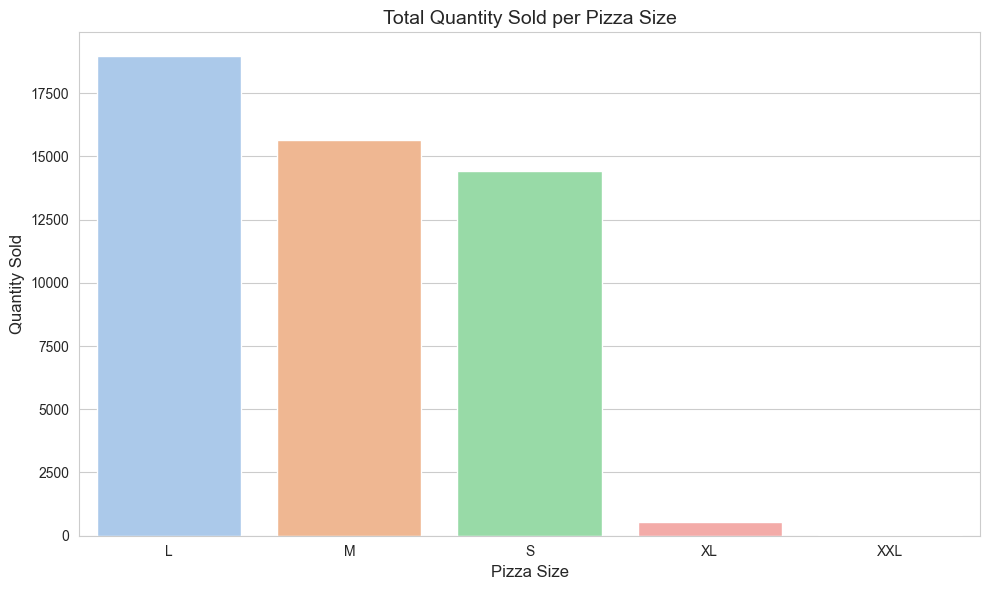

In [22]:
size_sales = data.groupby("pizza_size")["quantity"].sum().sort_values(ascending=False).reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=size_sales, x="pizza_size", y="quantity", hue="pizza_size", palette="pastel", legend=False)
plt.title("Total Quantity Sold per Pizza Size")
plt.xlabel("Pizza Size")
plt.ylabel("Quantity Sold")
plt.tight_layout()
plt.show()

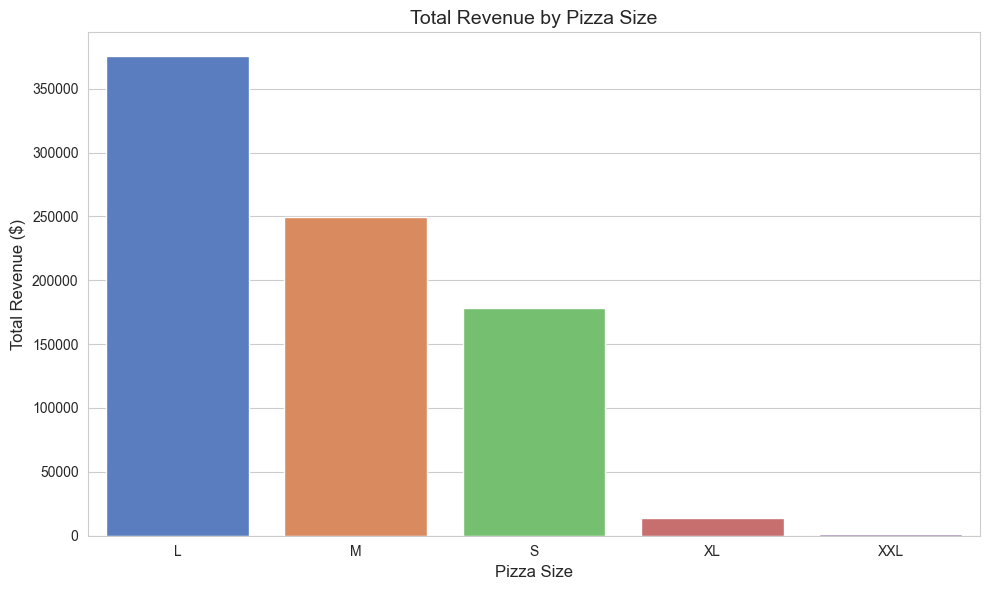

In [23]:
size_revenue = data.groupby("pizza_size")["total_price"].sum().sort_values(ascending=False).reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=size_revenue, x="pizza_size", y="total_price", hue="pizza_size", palette="muted", legend=False)
plt.title("Total Revenue by Pizza Size")
plt.xlabel("Pizza Size")
plt.ylabel("Total Revenue ($)")
plt.tight_layout()
plt.show()

### Pizza Sales Volume and Revenue Trends

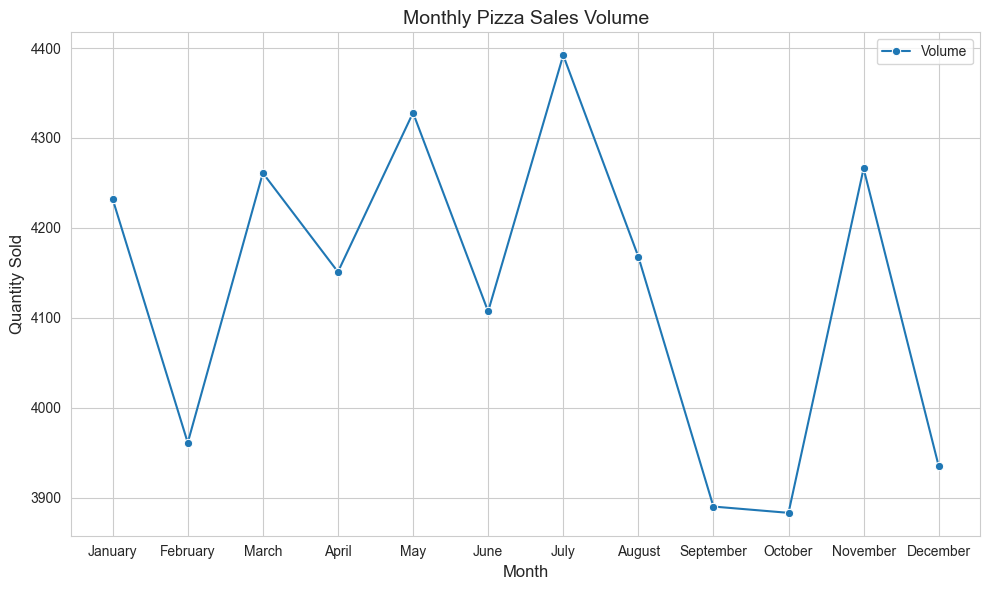

In [24]:
# Monthly
monthly_volume = data.groupby("order_month", observed=False)["quantity"].sum().reindex(MONTH_ORDER).reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_volume, x="order_month", y="quantity", marker="o", label="Volume")
plt.title("Monthly Pizza Sales Volume")
plt.xlabel("Month")
plt.ylabel("Quantity Sold")
plt.tight_layout()
plt.show()

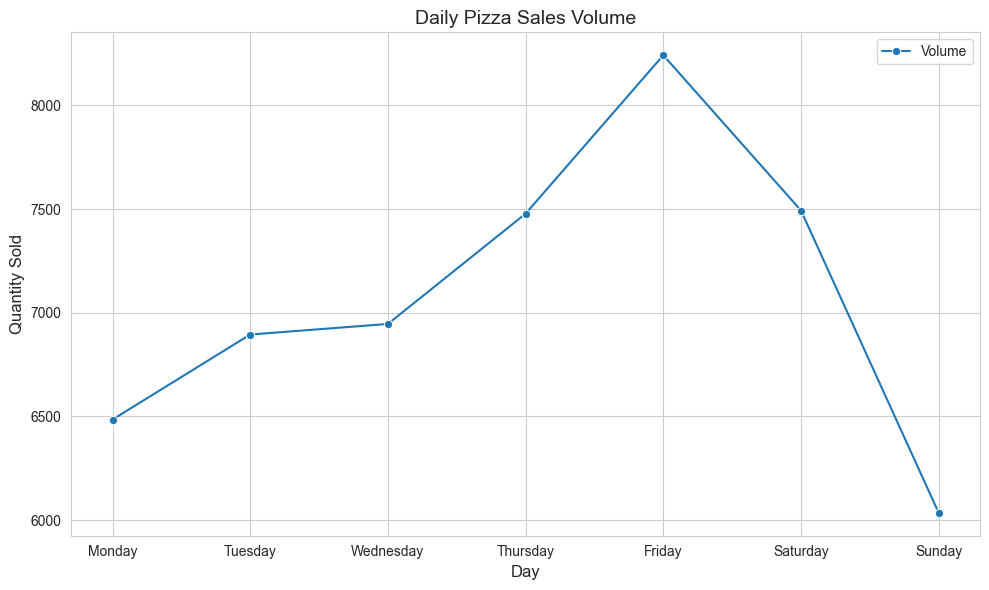

In [25]:
# Daily
daily_volume = data.groupby("order_dayname", observed=False)["quantity"].sum().reindex(DAY_ORDER).reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=daily_volume, x="order_dayname", y="quantity", marker="o", label="Volume")
plt.title("Daily Pizza Sales Volume")
plt.xlabel("Day")
plt.ylabel("Quantity Sold")
plt.tight_layout()
plt.show()

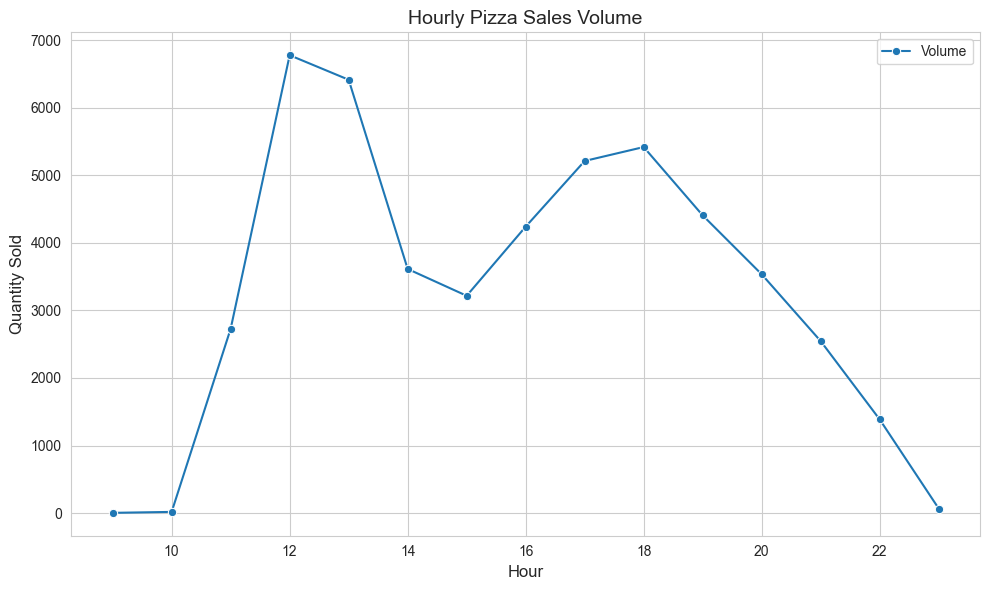

In [26]:
# Hourly
hourly_volume = data.groupby("hour")["quantity"].sum().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=hourly_volume, x="hour", y="quantity", marker="o", label="Volume")
plt.title("Hourly Pizza Sales Volume")
plt.xlabel("Hour")
plt.ylabel("Quantity Sold")
plt.tight_layout()
plt.show()

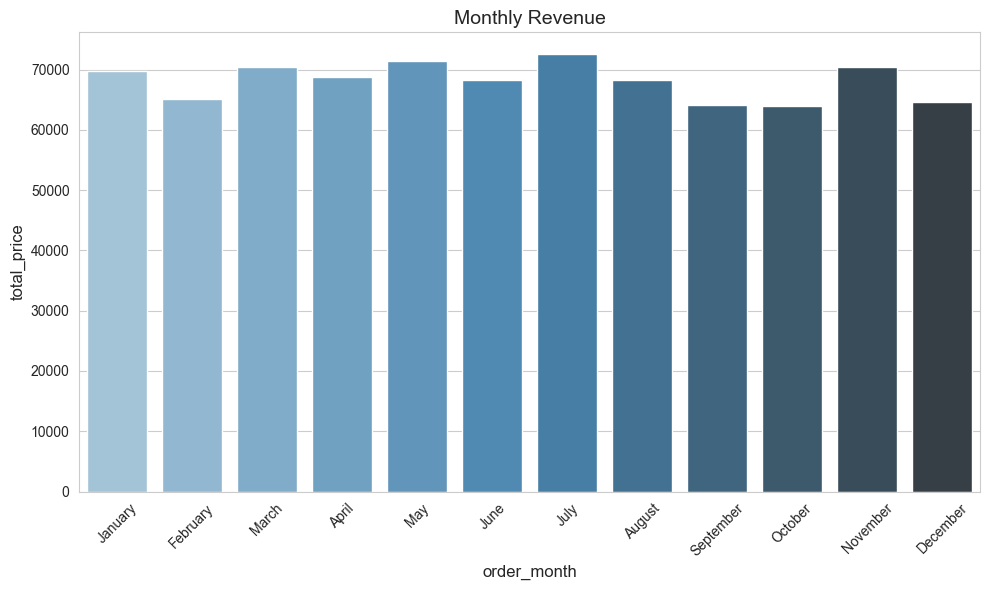

In [27]:
# Monthly Revenue
monthly_revenue = data.groupby("order_month", observed=False)["total_price"].sum().reindex(MONTH_ORDER).reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=monthly_revenue, x="order_month", y="total_price", hue="order_month", palette="Blues_d", legend=False)
plt.title("Monthly Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

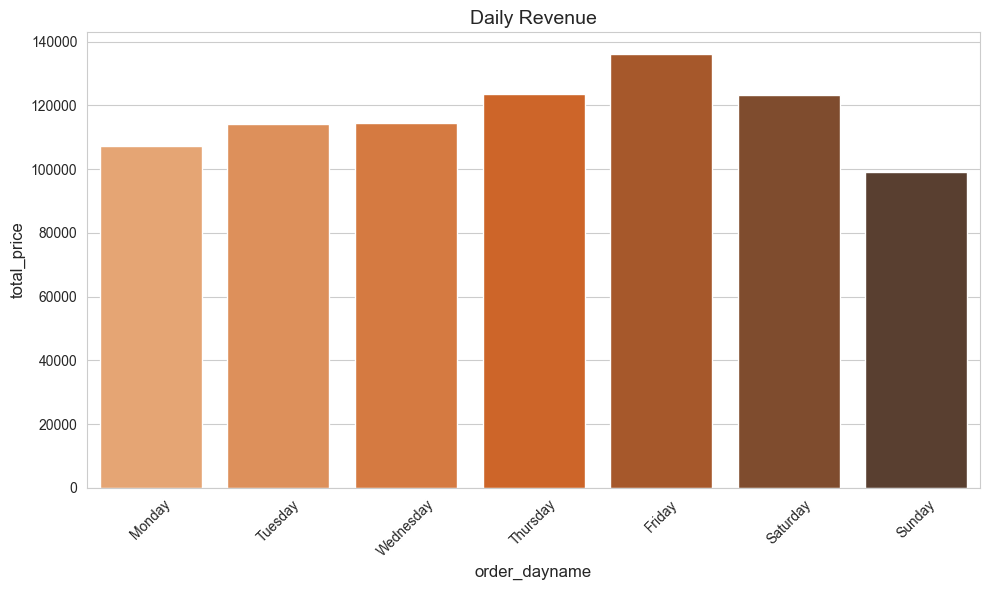

In [28]:
# Daily Revenue
daily_revenue = data.groupby("order_dayname", observed=False)["total_price"].sum().reindex(DAY_ORDER).reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=daily_revenue, x="order_dayname", y="total_price", hue="order_dayname", palette="Oranges_d", legend=False)
plt.title("Daily Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

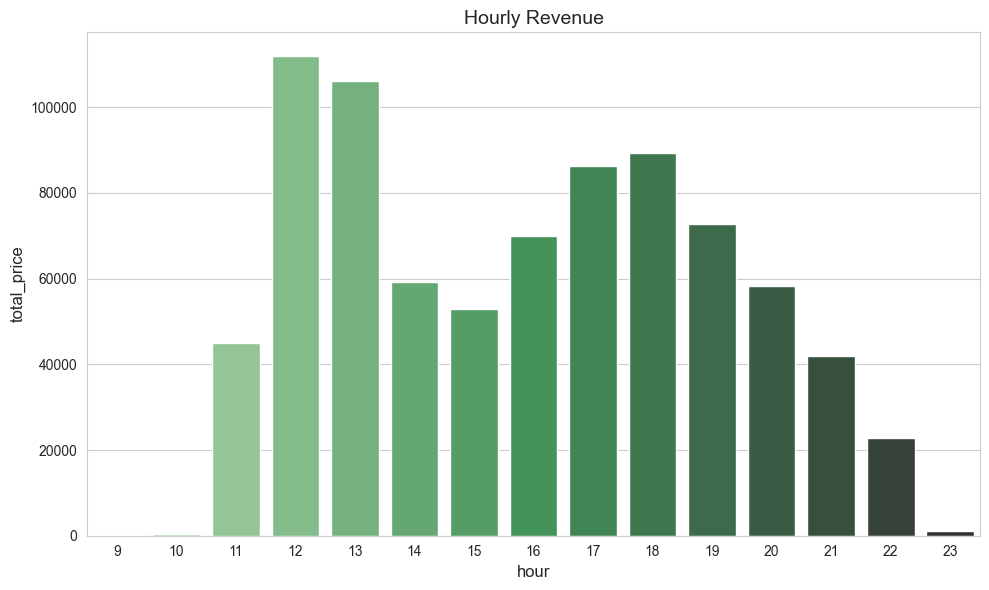

In [29]:
# Hourly Revenue
hourly_revenue = data.groupby("hour")["total_price"].sum().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=hourly_revenue, x="hour", y="total_price", hue="hour", palette="Greens_d", legend=False)
plt.title("Hourly Revenue")
plt.tight_layout()
plt.show()

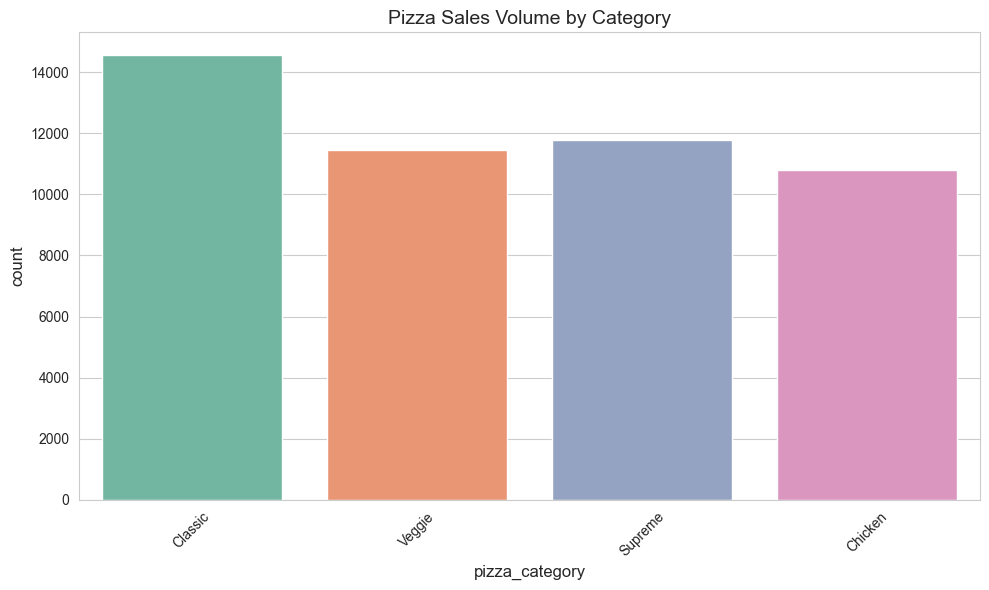

In [30]:
## Sales Volume by Category
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x="pizza_category", hue="pizza_category", palette="Set2", legend=False)
plt.title("Pizza Sales Volume by Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

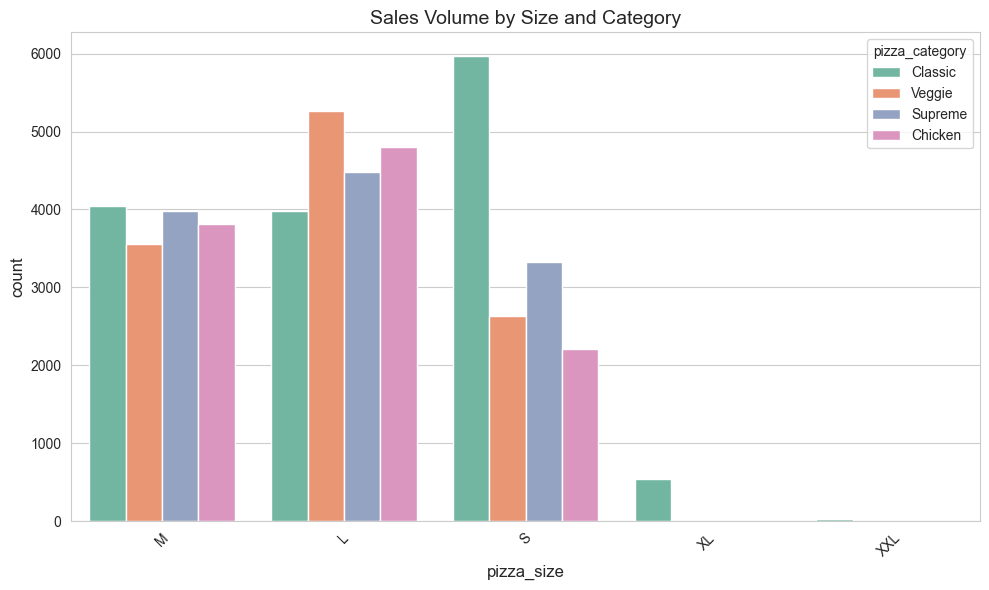

In [31]:
## Sales Volume by Size
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x="pizza_size", hue="pizza_category", palette="Set2")
plt.title("Sales Volume by Size and Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

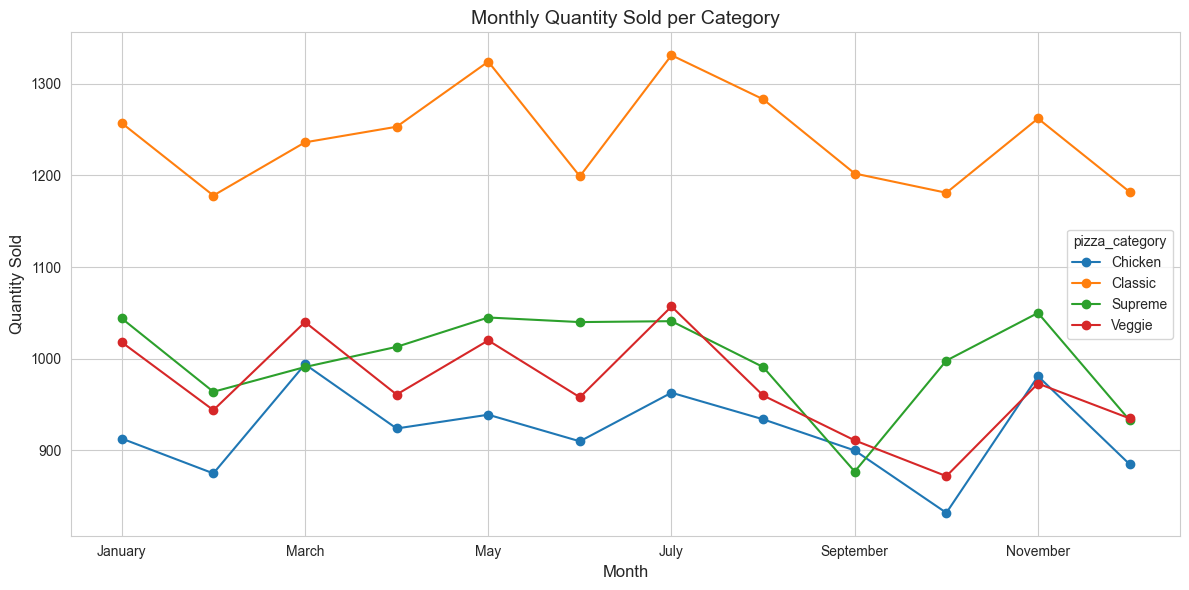

In [32]:
## Monthly Sales Trends
monthly_qty = data.groupby(['order_month', 'pizza_category'], observed=False)['quantity'].sum().unstack().reindex(MONTH_ORDER)
monthly_qty.plot(marker='o', figsize=(12, 6), title="Monthly Quantity Sold per Category")
plt.xlabel("Month")
plt.ylabel("Quantity Sold")
plt.grid(True)
plt.tight_layout()
plt.show()

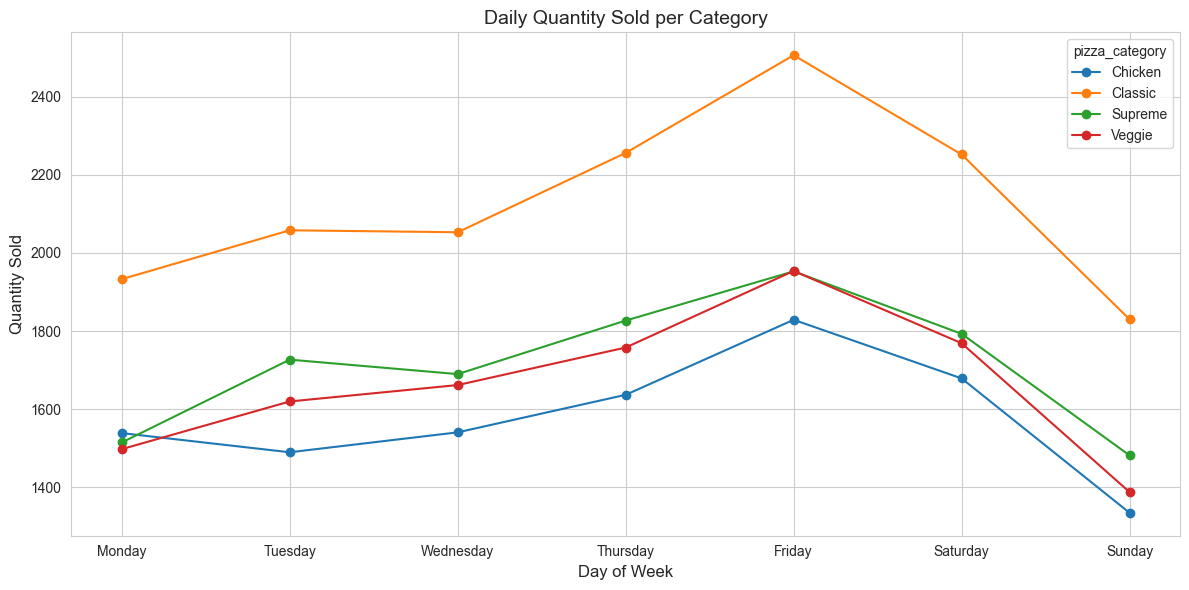

In [33]:
## Daily Sales Trends
daily_qty = data.groupby(['order_dayname', 'pizza_category'], observed=False)['quantity'].sum().unstack().reindex(DAY_ORDER)
daily_qty.plot(marker='o', figsize=(12, 6), title="Daily Quantity Sold per Category")
plt.xlabel("Day of Week")
plt.ylabel("Quantity Sold")
plt.grid(True)
plt.tight_layout()
plt.show()

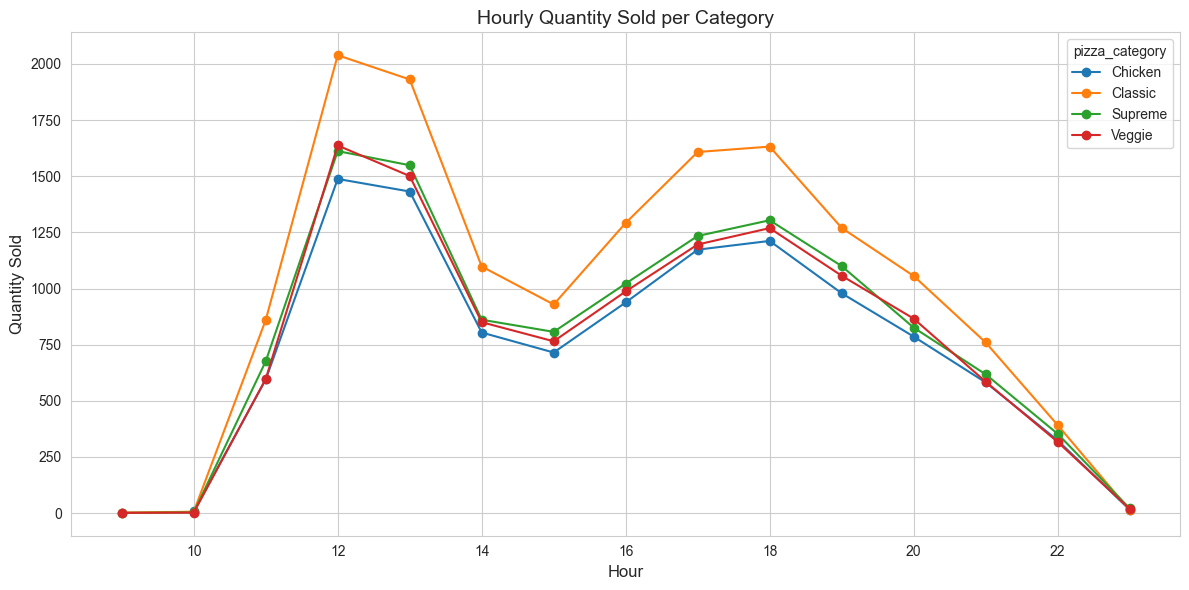

In [34]:
## Hourly Sales Trends
hourly_qty = data.groupby(['hour', 'pizza_category'])['quantity'].sum().unstack()
hourly_qty.plot(marker='o', figsize=(12, 6), title="Hourly Quantity Sold per Category")
plt.xlabel("Hour")
plt.ylabel("Quantity Sold")
plt.grid(True)
plt.tight_layout()
plt.show()

### Top & Bottom Performing Products by Category

In [35]:
def top_bottom_products(category, top=True, n=5):
    subset = data[data['pizza_category'] == category]
    grouped = subset.groupby("pizza_name")['quantity'].sum().sort_values(ascending=not top)
    return grouped.head(n)

In [36]:
for cat in data['pizza_category'].unique():
    print(f"Top 5 Pizzas in {cat} Category:\n", top_bottom_products(cat, top=True))
    print(f"Lowest 5 Pizzas in {cat} Category:\n", top_bottom_products(cat, top=False))
    print("\n")

Top 5 Pizzas in Classic Category:
 pizza_name
The Classic Deluxe Pizza    2453
The Hawaiian Pizza          2422
The Pepperoni Pizza         2418
The Big Meat Pizza          1914
The Napolitana Pizza        1464
Name: quantity, dtype: int64
Lowest 5 Pizzas in Classic Category:
 pizza_name
The Pepperoni, Mushroom, and Peppers Pizza    1359
The Greek Pizza                               1420
The Italian Capocollo Pizza                   1438
The Napolitana Pizza                          1464
The Big Meat Pizza                            1914
Name: quantity, dtype: int64


Top 5 Pizzas in Veggie Category:
 pizza_name
The Four Cheese Pizza                1902
The Vegetables + Vegetables Pizza    1526
The Mexicana Pizza                   1484
The Spinach and Feta Pizza           1446
The Five Cheese Pizza                1409
Name: quantity, dtype: int64
Lowest 5 Pizzas in Veggie Category:
 pizza_name
The Mediterranean Pizza          934
The Spinach Pesto Pizza          970
The Italian Vegetab

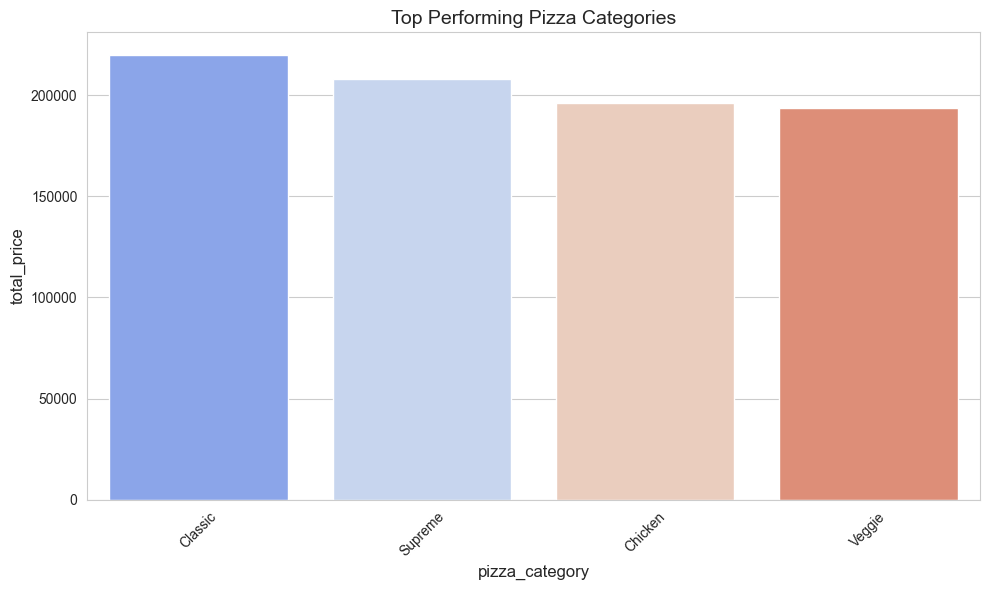

In [37]:
# --- Top Categories by Revenue ---
top_cat_revenue = data.groupby("pizza_category", observed=False)["total_price"].sum().sort_values(ascending=False).reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=top_cat_revenue, x="pizza_category", y="total_price", hue="pizza_category", palette="coolwarm", legend=False)
plt.title("Top Performing Pizza Categories")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Sales Analysis Overview

The sales analysis section provides a comprehensive breakdown of pizza performance across time, categories, sizes, and customer preferences.

###  Key Highlights

- **Total Revenue:**  
  - The business generated **$817,860.05** over the entire period.
  - The **average transaction value** was approximately **$16.82**, indicating healthy per-order spend.

- **Top-Selling Pizzas:**  
  - Most frequently purchased pizzas include:
    - The Classic Deluxe Pizza
    - The Barbecue Chicken Pizza
    - The Hawaiian Pizza  
  These products are the **main revenue drivers** and should be prioritized in promotions and inventory planning.

- **Sales by Pizza Category:**  
  - The business offers 4 main categories: **Classic, Chicken, Supreme, Veggie**.
  - The **Classic** category recorded the highest overall quantity sold as well as highest revenue.
  - Category-based performance was also analyzed across top and bottom 5 pizzas per group, helping to spot underperformers.

### Sales by Size

- **Quantity Sold by Size:**  
  - **Large-sized pizzas** dominated in terms of sales volume.
  - Extra-Exta-Large-sized pizzas recorded the least number of sales, indicating customer preference for shared or group-sized meals.

- **Revenue by Size:**  
  - As expected, **large pizzas** also contribute the most to revenue.
  - This suggests that optimizing deals around large sizes (e.g., bundle offers) could boost revenue further.

### Time-Based Sales Trends

- **Monthly Trends:**  
  - Pizza sales peak during months like **July and August**, likely due to seasonal events.
  - Sales remain relatively steady across most months, indicating consistent demand.

- **Daily Trends:**  
  - Weekends, especially **Friday**, has the highest sales volumes.
  - Sundays tend to be the slowest, ideal for launching promotional offers to boost traffic.

- **Hourly Trends:**  
  - Peak order hours are between **12 PM and 1 PM**, and **5 PM to 8 PM**, aligning with lunch and dinner rushes.
  - These insights support targeted marketing (e.g., flash discounts during low traffic hours).

### Revenue Distribution

- Revenue trends mirror quantity sold but with key differences:
  - Certain categories and sizes, though sold less frequently, have **higher average revenue per order**.
  - This suggests an opportunity to **promote higher-margin products** more strategically.

---



# Market Basket Analysis

In [38]:
# Group the data into transactions using the 'order_id' column.
# Then transform the DataFrame into a list of lists, where each list contains the itemset assigned to a transaction.
transactions = data.groupby(['order_id'])['pizza_category'].apply(list).to_list()
print(len(transactions))

21350


In [39]:
# Transforming the data into a "one-hot encoded Boolean array".
encoder = TransactionEncoder()
encoded_array = encoder.fit(transactions).transform(transactions)
data_itemsets = pd.DataFrame(encoded_array, columns=encoder.columns_)

In [40]:
# To confirm that the original list is still intact.
print('Number of transactions: ', len(transactions))
print('Number of unique items: ', len(set(sum(transactions, []))))

Number of transactions:  21350
Number of unique items:  4


In [41]:
frequent_itemsets = apriori(data_itemsets, min_support=0.005, use_colnames=True)
frequent_itemsets["length"] = frequent_itemsets["itemsets"].apply(len)
multi_itemsets = frequent_itemsets[frequent_itemsets['length'] >= 2]

In [42]:
print(f"Total frequent itemsets: {len(frequent_itemsets)}")
print(f"Multi-item itemsets (len >= 2): {len(multi_itemsets)}")

Total frequent itemsets: 15
Multi-item itemsets (len >= 2): 11


In [43]:
print(frequent_itemsets[['itemsets', 'support', 'length']])

                               itemsets   support  length
0                             (Chicken)  0.399813       1
1                             (Classic)  0.508618       1
2                             (Supreme)  0.425527       1
3                              (Veggie)  0.418782       1
4                    (Chicken, Classic)  0.179297       2
5                    (Chicken, Supreme)  0.149180       2
6                     (Veggie, Chicken)  0.149040       2
7                    (Supreme, Classic)  0.186136       2
8                     (Veggie, Classic)  0.189274       2
9                     (Veggie, Supreme)  0.154801       2
10          (Supreme, Chicken, Classic)  0.073864       3
11           (Veggie, Chicken, Classic)  0.077049       3
12           (Veggie, Chicken, Supreme)  0.062623       3
13           (Supreme, Veggie, Classic)  0.076815       3
14  (Supreme, Veggie, Chicken, Classic)  0.035363       4


In [44]:
if not multi_itemsets.empty:
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
    rules = rules[rules['antecedents'].apply(len) + rules['consequents'].apply(len) >= 2]
    rules = rules[(rules['confidence'] >= 0.25) & (rules['lift'] >= 1.0)]
    rules_sorted = rules.sort_values(by="lift", ascending=False)
    print(rules_sorted[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())
else:
    print("Still no frequent multi-itemsets found. Try lowering support further.")

                    antecedents consequents   support  confidence      lift
11   (Veggie, Classic, Supreme)   (Chicken)  0.035363    0.460366  1.151454
12  (Classic, Chicken, Supreme)    (Veggie)  0.035363    0.478757  1.143213
10   (Veggie, Chicken, Supreme)   (Classic)  0.035363    0.564697  1.110257
13   (Veggie, Chicken, Classic)   (Supreme)  0.035363    0.458967  1.078584
2            (Chicken, Classic)    (Veggie)  0.077049    0.429728  1.026138


## Vissuals

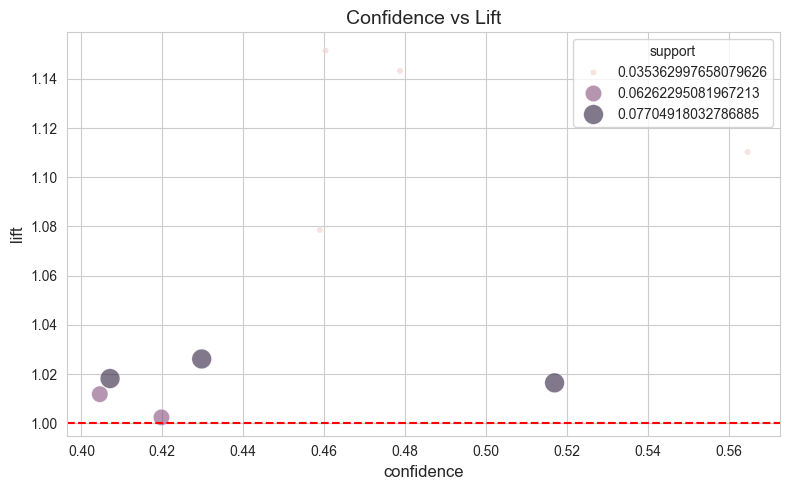

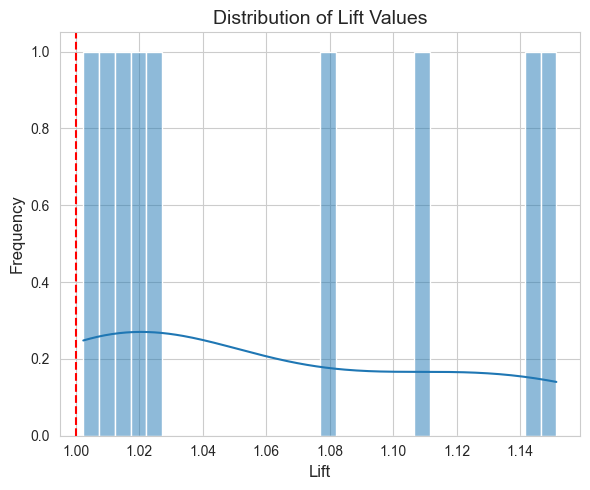

In [45]:
if not rules_sorted.empty:
    # Plot scatter plot
    plt.figure(figsize=(8, 5))
    sns.scatterplot(
        data=rules_sorted,
        x="confidence",
        y="lift",
        hue="support",
        size="support",
        sizes=(20, 200),
        alpha=0.6
    )
    plt.axhline(1, color="red", linestyle="--")
    plt.title("Confidence vs Lift")
    plt.tight_layout()
    plt.show()

    # Plot histogram of lift
    plt.figure(figsize=(6, 5))
    sns.histplot(rules_sorted["lift"], bins=30, kde=True)
    plt.axvline(1, color="r", linestyle="--")
    plt.title("Distribution of Lift Values")
    plt.xlabel("Lift")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
else:
    print("No association rules found. Skipping visualizations.")

## Creating a dsicount plan

In [46]:
def create_discount_plan(rules_df, lift_threshold=1.0, confidence_threshold=0.3):
    plan = rules_df[
        (rules_df['lift'] >= lift_threshold) &
        (rules_df['confidence'] >= confidence_threshold)
    ]
    
    if plan.empty:
        print("No rules meet the current lift and confidence thresholds.")
        return []
    
    suggestions = [
        f"Offer a discount on {list(row['consequents'])[0]} "
        f"when a customer orders {', '.join(row['antecedents'])}."
        for _, row in plan.iterrows()
    ]
    return suggestions

# Run the function
discount_recommendations = create_discount_plan(rules_sorted)

# Print the output
if discount_recommendations:
    print("Discount Recommendations:")
    for i, rec in enumerate(discount_recommendations, start=1):
        print(f"{i}. {rec}")
else:
    print("No discount suggestions generated.")


Discount Recommendations:
1. Offer a discount on Chicken when a customer orders Veggie, Classic, Supreme.
2. Offer a discount on Veggie when a customer orders Classic, Chicken, Supreme.
3. Offer a discount on Classic when a customer orders Veggie, Chicken, Supreme.
4. Offer a discount on Supreme when a customer orders Veggie, Chicken, Classic.
5. Offer a discount on Veggie when a customer orders Chicken, Classic.
6. Offer a discount on Chicken when a customer orders Veggie, Classic.
7. Offer a discount on Classic when a customer orders Veggie, Chicken.
8. Offer a discount on Chicken when a customer orders Veggie, Supreme.
9. Offer a discount on Veggie when a customer orders Chicken, Supreme.


In [47]:
print(f"{len(rules_sorted)} association rules generated.")

9 association rules generated.


## Market Basket Analysis Conclusion

After iterative refinement of the Market Basket Analysis, I identified meaningful patterns in customer ordering behavior by adjusting several parameters:

- **Minimum Support**: Reduced to `0.005` to capture less frequent, yet valuable combinations.
- **Metric & Thresholds**: Applied `lift ≥ 1.0` and `confidence ≥ 0.25` to surface realistic and interpretable rules.
- **Grouping Level**: Switched from `pizza_name` to `pizza_category` to reduce data sparsity and reveal higher-level patterns.

### Key Insights

1. **Frequent category combinations** were discovered:
   - Customers often purchase across **Veggie**, **Classic**, **Chicken**, and **Supreme** categories.
   - Example Rule:  
     _“If a customer orders Classic, Veggie, and Supreme, they are also likely to order Chicken.”_

2. **Cross-selling & combo creation opportunities**:
   - Suggesting a missing category from a frequently paired set can improve upselling.
   - These combinations provide a strong foundation for combo meal bundles or personalized recommendations.

3. **Refined thresholds revealed hidden insights**:
   - High `support` and `confidence` thresholds initially missed valuable category-level patterns.
   - The updated parameters allowed for exploratory yet actionable findings.

4. **Category-level patterns were more informative than product-level**:
   - With 30+ unique pizza names, product-level rules were sparse.
   - Aggregating to `pizza_category` improved result strength and generalizability.

### Business Application

- **Recommendation System**: Suggest a missing pizza category based on current order combinations.
- **Discount Plan**: Offer category-based promotions, e.g.,  
  _“Buy any 3 categories, get the 4th at 15% off.”_
- **Bundle Strategy**: Design combo offers aligned with these frequent category combinations.

### Lessons Learned

- Analyzing by `pizza_name` did not yield multi-itemsets due to low frequency and high variability.
- Category aggregation is crucial for uncovering consistent, repeatable customer behavior.

---

This analysis informs us that **customers show repeatable category-level co-purchasing behavior**, and **data-driven bundling or cross-selling strategies** can enhance both revenue and customer satisfaction.


# Customer Segmentaion

In [48]:
# Prepare Customer Summary Statistics
customer_data = data.groupby("order_id").agg({
    "total_price": "sum",
    "pizza_name": pd.Series.nunique,
    "pizza_size": "count"
}).rename(columns={
    "total_price": "Total_Spent",
    "pizza_name": "Unique_Pizzas",
    "pizza_size": "Total_Items"
})

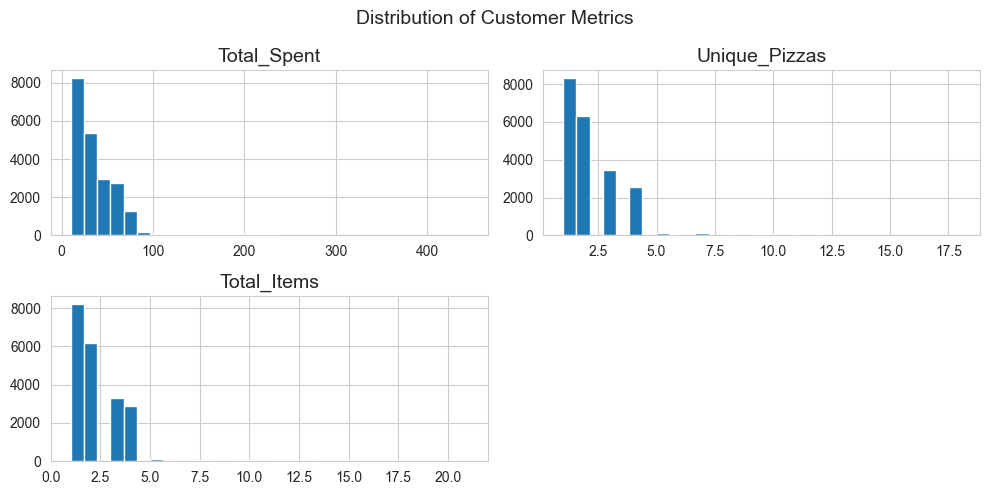

In [49]:
# Explore Data Distribution
customer_data.hist(bins=30, figsize=(10, 5))
plt.suptitle("Distribution of Customer Metrics", fontsize=14)
plt.tight_layout()
plt.show()

In [50]:
# Scale Features for Clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data)

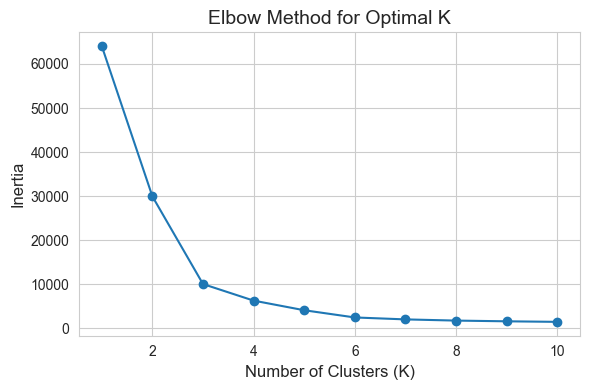

In [51]:
# Use Elbow Method to Determine Optimal Number of Clusters
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K_range, inertia, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.grid(True)
plt.tight_layout()
plt.show()

In [52]:
# Step 5: Apply KMeans Clustering with Chosen K (e.g., 3)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
customer_data["Cluster"] = kmeans.fit_predict(scaled_data)

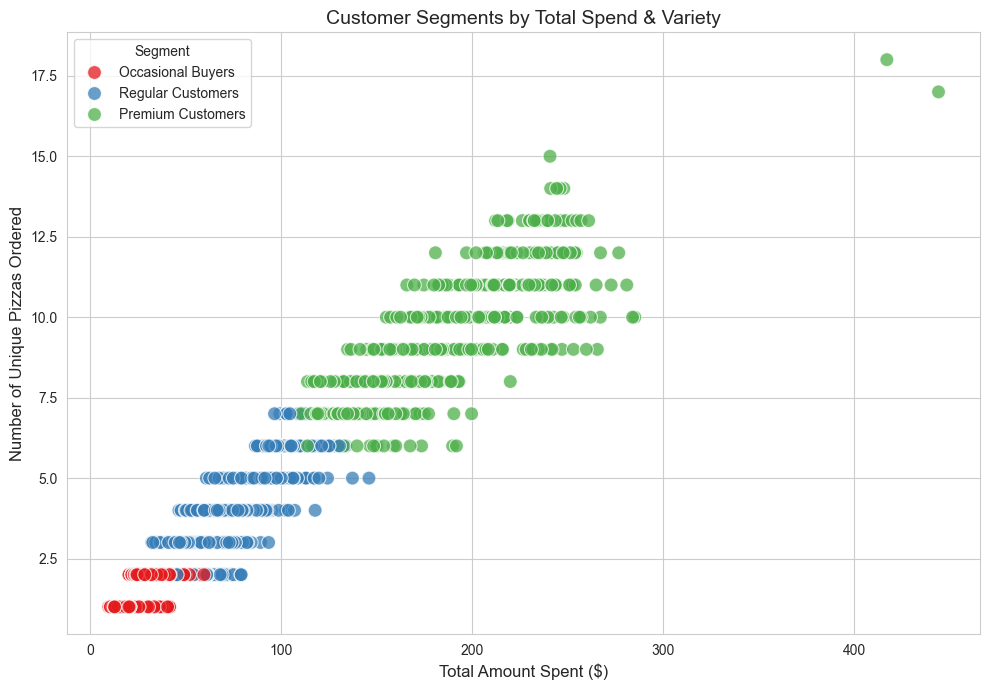

In [53]:
# Map cluster numbers to labels
cluster_labels = {
    0: "Regular Customers",
    1: "Premium Customers",
    2: "Occasional Buyers"
}

# Create a new column for descriptive labels
customer_data["Segment"] = customer_data["Cluster"].map(cluster_labels)

# Visualize using the segment labels
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=customer_data,
    x="Total_Spent",
    y="Unique_Pizzas",
    hue="Segment",
    palette="Set1",
    s=100,
    alpha=0.75
)
plt.title("Customer Segments by Total Spend & Variety")
plt.xlabel("Total Amount Spent ($)")
plt.ylabel("Number of Unique Pizzas Ordered")
plt.grid(True)
plt.tight_layout()
plt.show()


### Segment Profiling Summary

To better understand and communicate customer behavior, the numeric cluster labels (0, 1, 2) were mapped to descriptive customer segments:

- **Occasional Buyers**: Low spenders who order only 1–2 unique pizza types occasionally.
- **Regular Customers**: Mid-level spenders who show moderate variety in orders.
- **Premium Customers**: High-value customers who frequently purchase a wide variety of pizzas with large order volumes.

This profiling helps translate raw cluster data into meaningful business insights that can guide targeted promotions, customer retention strategies, and loyalty campaigns.

Below is a breakdown of key metrics (average, minimum, maximum) across each segment:


In [54]:
segment_summary = customer_data.groupby("Segment").agg({
    "Total_Spent": ["mean", "min", "max"],
    "Unique_Pizzas": ["mean", "min", "max"],
    "Total_Items": ["mean", "min", "max"],
    "Cluster": "count"
}).round(2)

print("\n Segment Summary:\n")
print(segment_summary)



 Segment Summary:

                  Total_Spent                 Unique_Pizzas          \
                         mean     min     max          mean min max   
Segment                                                               
Occasional Buyers       23.85    9.75   59.55          1.42   1   2   
Premium Customers      187.75  110.45  444.20          9.38   6  18   
Regular Customers       59.29   32.25  145.95          3.45   2   7   

                  Total_Items         Cluster  
                         mean min max   count  
Segment                                        
Occasional Buyers        1.43   1   3   14398  
Premium Customers       10.47   7  21     485  
Regular Customers        3.54   2   7    6467  


## Customer Segmentation Insights

Based on K-Means clustering, customers were segmented into three distinct groups. The profiling below highlights their behavioral patterns:


### Premium Customers
- **Average Spend:** ~$188  
- **Average Unique Pizzas Ordered:** ~9.4  
- **Average Items per Order:** ~10.5  
-  These are high-value customers who place large and diverse orders. Likely to be bulk buyers or highly loyal. Best suited for:
  - Loyalty programs  
  - Exclusive discount offers  
  - Early access to new items


### Regular Customers
- **Average Spend:** ~$59  
- **Average Unique Pizzas Ordered:** ~3.5  
- **Average Items per Order:** ~3.5  
-  These customers order moderately and regularly. They appreciate variety and are ideal for:
  - Combo promotions  
  - Upselling/cross-selling offers  
  - Personalized deals


### Occasional Buyers
- **Average Spend:** ~$24  
- **Average Unique Pizzas Ordered:** ~1.4  
- **Average Items per Order:** ~1.4  
-  These are low-engagement customers who may have ordered only once or very infrequently. They can be re-engaged through:
  - Reminder emails or SMS  
  - First-order discount follow-ups  
  - Time-limited special offers


**Business Implication:**  
Understanding these segments allows for proper marketing strategies that improve retention, increase average order value, and foster customer loyalty.


## Variable Selection Rationale
---
In this notebook, I strategically used different variables for our two major analyses — Market Basket Analysis and Customer Segmentation — based on the nature and objective of each task.

### Market Basket Analysis
- **Variable Used:** `pizza_category`
- **Reason:**  
  - Using categories reduces the complexity of combinations and highlights broader purchasing patterns.
  - It helps identify which **types of pizzas** are often bought together, which is useful for bundle offers and promotions.
  - Examples of associations found: "Customers who buy Classic often also buy Veggie."

### Customer Segmentation
- **Variable Used:** `pizza_name`
- **Reason:**  
  - I needed a more detailed view of each customer’s unique order behavior.
  - Using `pizza_name` lets us capture the **diversity and quantity** of individual pizzas ordered.
  - This level of granularity is essential for profiling customers as Occasional Buyers, Regulars, or Premium Customers.

### Summary
The variable choices are deliberate and aligned with best practices in data analysis:
- Use **categories** for broad association patterns.
- Use **detailed product names** for personalized customer insights.

These decisions ensure clarity, precision, and relevance in the business recommendations we generate.


## Final Executive Summary
---
This project offers a data-driven strategic review of a pizza sales business, utilizing analytics and unsupervised learning techniques to uncover actionable insights. The workflow is segmented into three core areas:



### 1. Sales Performance & Behavior

- Revenue is consistently driven by **large-sized pizzas** and **Classic category items**.
- **Peak sales** occur on Fridays and during lunch/dinner hours.
- Certain pizzas (e.g., *Classic Deluxe, Barbecue Chicken*) dominate sales and should be prioritized in campaigns.
- Low-performing SKUs (Stock Keeping Unit) can be reviewed for possible retirement or repositioning.



### 2. Product Affinity & Upselling Opportunities (Market Basket Analysis)

- By aggregating purchases at the **pizza_category** level, I identified strong co-purchase patterns.
- **Frequent combinations** such as *Classic + Veggie + Chicken* suggest ideal bundles or meal deals.
- A rule-based **discount recommendation engine** was developed to encourage basket expansion, based on `lift` and `confidence` metrics.



### 3. Customer Segmentation & Targeting

- Three distinct customer profiles emerged:
  - **Premium Customers**: High-value bulk buyers (~$188 average spend)
  - **Regular Customers**: Medium-frequency spenders (~$59 average)
  - **Occasional Buyers**: Low-frequency, low-spend (~$24 average)
- These segments support precision targeting via **personalized offers**, **re-engagement strategies**, and **tiered loyalty programs**.



### Strategic Takeaways

- **Data-Driven Promotions**: Use association rules to create smart bundles that align with natural purchasing behavior.
- **Customer-Centric Marketing**: Tailor offers and discounts by customer segment to maximize ROI.
- **Inventory & Product Strategy**: Prioritize high-margin, high-frequency SKUs while reevaluating underperformers.
- **Scalability**: The analysis structure can be extended to real-time dashboards or integrated into a POS recommendation engine.



**Conclusion:**  
This end-to-end analysis combines exploratory analytics with machine learning to deliver **insight, segmentation, and strategy**. It bridges the gap between raw data and business value, aligning perfectly with modern data anslysis and data science practices that focus on measurable outcomes and user-centric decisions.
